In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from gee_scripts.parameters import explain_vars, response_var, west_region_ids, center_region_ids
from scipy.stats import pearsonr
from gee_scripts.models import get_random_forest, get_regressors
import tensorflow as tf
from sklearn.discriminant_analysis import StandardScaler
from gee_scripts.models import split_dataset


2024-06-10 14:19:33.164792: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 14:19:33.166276: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 14:19:33.190088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-10 14:19:33.190945: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 14:19:33.969467: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [ ]:
# # split the training_df into training and test where test is the last year

# # Train by year
# # train_data = train_df[train_df["date"].dt.year.isin([2020,2021,2022])]
# # test_data = train_df[train_df["date"].dt.year.isin([2023])]

# # # train and test selection by month
# # train_data = train_df[train_df["date"].dt.month.isin([1,2,4,5,7,8,10,11,12])]
# # test_data = train_df[train_df["date"].dt.month.isin([3,6,9])]

# X_train, X_test = train_data[explain_vars], test_data[explain_vars]
# y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

# print("lenght of train and test", len(X_train), len(X_test))

# ####################### TRAIN THE MODEL ############################

# regr.fit(X_train, y_train)
# y_pred_test = regr.predict(X_test)

# r, p = pearsonr(y_test, y_pred_test)
# r2_score_val = r2_score(y_test, y_pred_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# # print all the metrics
# print(f"r2_score: {r2_score_val}")
# print(f"rmse: {rmse}")
# print(f"pearson r: {r}")
# print(f"p-value: {p}")

# # Plot the observed vs predicted with labels and title
# plt.scatter(y_test, y_pred_test)
# plt.xlabel("Observed")
# plt.ylabel("Predicted")
# plt.title("Observed vs Predicted")
# plt.show()

# 1. Read training data

In [ ]:
df = pd.read_csv("data/9_clean_training_data/all_training_data_with_extra_and_locations_and_precipSum.csv", parse_dates=["date"])
df = df[df.region_id.isin(center_region_ids)]
# assert df[["date"]].dtypes.iloc[0] == "datetime64[ns]"
len(df)

In [ ]:
# filter_condition = df.phu_id==71
# train_df = df[filter_condition]
# len(train_df)

In [ ]:
# get a boxplot of response var per region but use a small graph size

# set the seaborn style and size
# sns.set_style("whitegrid");
# sns.set(rc={'figure.figsize':(8,5)});
# sns.boxplot(x="region_id", y="gwl_cm", data=train_df, width=0.5)

In [ ]:
# # Get a table with the count of the number of observations per month
# train_df["month"] = train_df["date"].dt.month
# train_df["year"] = train_df["date"].dt.year
# train_df["month_year"] = train_df["date"].dt.to_period('M')
# train_df[train_df.id == "15_RAPP_LGBI-001a"].groupby("month_year").size().reset_index(name='counts')

In [ ]:
# train_df["date"] = pd.to_datetime(train_df["date"])
# get_precipitation_plot(train_df, group_by="station", value="15_RAPP_LGBI-001a")

In [ ]:
# # group by id and get the number of dates for each id
# group_by = "id"
# df_grouped = train_df.groupby(group_by).count().reset_index()
# df_grouped = df_grouped[[group_by, "date"]]
# df_grouped.columns = ["name", "date_count"]
# df_grouped.sort_values(by="date_count", ascending=False);

In [ ]:
# # drop all stations with less tan 9 observations
# min_obs = 0
# train_df.groupby('id').agg({'date': 'count'}).sort_values(by='date', ascending=False).reset_index()
# train_df = train_df.groupby('id').filter(lambda group: len(group) >= min_obs)

In [ ]:
# running cross validation on 23 phu_ids
# processing phu_id 407.0 with No. of observations 199
# Splitting by station with 34 categories


In [ ]:
x_df = df[df.phu_id==407]

In [ ]:
(next(iter(split_dataset(x_df, test_size=0.2, by="station"))))

In [ ]:
train_df, test_df = next(iter(split_dataset(x_df, test_size=0.2, by="year")))

In [ ]:
def evaluate_models(data, target_column, n_splits):
    """Evaluate the performance of different regression models on the dataset using cross-validation."""

    data = data.copy()

    results = []
    
    # Loop through each split type
    for split_type in ["station", "year", "month"]:
        
        train_test_splits = split_dataset(data, by=split_type, n_splits=n_splits)

        if split_type == "station":
            split_type = "id"

        for train_data, test_data in train_test_splits:

            if len(test_data) == 0:
                results.append({
                    "phu_id": data["phu_id"].iloc[0],
                    "split_type": split_type,
                    "no_obs": len(data),
                    "train_obs": 0,
                    "test_obs": 0,
                    "estimator_name": None,
                    "validation" : f"cross validation {split_type}",
                    "test_ids": None,
                    "train_ids": None,
                    "r2_score": None,
                    "rmse": None,
                    "pearson_r": None,
                    "p_value": None,
                })
                continue
            
            X_train, X_test = train_data[explain_vars], test_data[explain_vars]
            y_train, y_test = train_data[target_column], test_data[target_column]

            input_dim = X_train.shape[1]  # Number of explanatory variables

            for regr in get_regressors(input_dim):
                print(f"Training {regr.__class__.__name__} on {len(train_data)} observations and testing on {len(test_data)} observations")

                if isinstance(regr, tf.keras.Model):  # Check if the model is a Keras model
                    # Neural network requires normalization and batch processing
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_test_scaled = scaler.transform(X_test)
                    
                    # Fit the model
                    regr.fit(X_train_scaled, y_train, epochs=5, batch_size=8, verbose=0)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test_scaled).flatten()  # Flatten to convert 2D predictions to 1D
                else:
                    # Fit traditional models
                    regr.fit(X_train, y_train)
                    
                    # Predict
                    y_pred_test = regr.predict(X_test)


                r, p = pearsonr(y_test, y_pred_test)
                r2_score_val = r2_score(y_test, y_pred_test)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

                results.append({
                    "phu_id": train_data["phu_id"].iloc[0],
                    "no_obs": len(data),
                    "train_obs": len(train_data),
                    "test_obs": len(test_data),
                    "estimator_name": regr.__class__.__name__,
                    "validation" : f"cross validation {split_type}",
                    "train_ids": train_data[split_type].unique(),
                    "test_ids": test_data[split_type].unique(),
                    "r2_score": r2_score_val,
                    "rmse": rmse,
                    "pearson_r": r,
                    "p_value": p,
                })

    return results

In [ ]:
phu_cross_validation_results = []
print(f"running cross validation on {df.phu_id.nunique()} phu_ids")
for phu_id in df.phu_id.unique():
    if  pd.isnull(phu_id):
        continue
    print("processing phu_id", phu_id, "with No. of observations", len(df[df.phu_id==phu_id]))
    filter_condition = df.phu_id==phu_id
    train_df = df[filter_condition]
    results = evaluate_models(train_df, "gwl_cm", n_splits=10)
    phu_cross_validation_results.extend(results)

In [ ]:
# # Create a dataframe from the results
# results_df = pd.DataFrame(phu_cross_validation_results)
# # results_df.to_csv("data/13_estimation_results/cross_validation_results.xlsx", index=False)

In [ ]:
# Sort the results by r2_score and phu_id
results_df.sort_values(by=["r2_score", "phu_id"], ascending=False, inplace=True)
results_df.to_csv("data/13_estimation_results/center_multiple_models_cross_validation_results_sorted.csv", index=False)

In [ ]:
plt.boxplot(evaluation_results)
plt.title('Model Performance Across Random Splits')
plt.ylabel('RMSE')
plt.show()

print("Average RMSE across splits:", np.mean(evaluation_results))


In [4]:
results_df = pd.read_csv("data/13_estimation_results/center_multiple_models_cross_validation_results_sorted_2.csv")

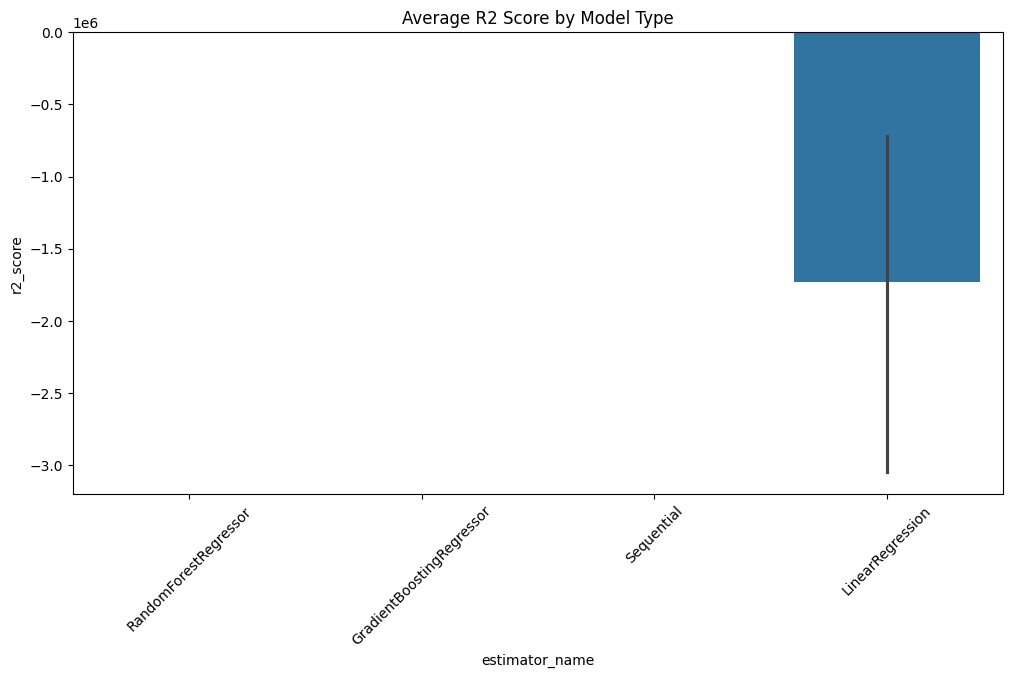

KeyError: 'split_type'

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming phu_cross_validation_results is a list of dictionaries
results_df = pd.DataFrame(results_df)

# Summary statistics
summary_stats = results_df[['r2_score', 'rmse', 'pearson_r']].describe()

# Performance by model type
model_performance = results_df.groupby('estimator_name')[['r2_score', 'rmse', 'pearson_r']].mean()

# Plotting model performance
plt.figure(figsize=(12, 6))
sns.barplot(x='estimator_name', y='r2_score', data=results_df)
plt.title('Average R2 Score by Model Type')
plt.xticks(rotation=45)
plt.show()

# Analyze performance by split type
split_performance = results_df.groupby('split_type')[['r2_score', 'rmse', 'pearson_r']].mean()

# Print the summary statistics and model performance
print(summary_stats)
print(model_performance)
print(split_performance)

# Handle failures
print("Failed PHUs:", failed_phus)


In [ ]:

# PCA TEST

# Divide train and test by PCA and year
# train_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & train_df["date"].dt.year.isin([2020,2021,2022])]
# test_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & train_df["date"].dt.year.isin([2023])]

# # Divide train and test by PCA and month
train_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & (train_df["date"].dt.month.isin([1,2,4,5,7,8,10,11,12]))]
test_data = train_df[train_df.id.isin(pca1_and_pca2_1stq_ids) & (train_df["date"].dt.month.isin([3,6,9]))]


X_train, X_test = train_data[explain_vars], test_data[explain_vars]
y_train, y_test = train_data["gwl_cm"], test_data["gwl_cm"]

print("lenght of train and test", len(X_train), len(X_test))

####################### TRAIN

regr = get_random_forest()

regr.fit(X_train, y_train)
y_pred_test = regr.predict(X_test)

r, p = pearsonr(y_test, y_pred_test)
r2_score_val = r2_score(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

# print all the metrics
print(f"r2_score: {r2_score_val}")
print(f"rmse: {rmse}")
print(f"pearson r: {r}")
print(f"p-value: {p}")

# Plot the observed vs predicted with labels and title
plt.scatter(y_test, y_pred_test)
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted")
plt.show()

In [ ]:

print("dependent var", response_var)
print("explanatory lenght", len(explain_vars))
print(explain_vars)

In [ ]:
# bootstrap_result = bootstrap(df = train_df, variable="gwl_cm", iterations=100, train_size=0.8, explain_vars=explain_vars, bootstrap_by="observations")
# bootstrap_result

In [ ]:
# Now I want to test the model on unseen data and see how it performs
from gee_scripts.models import get_random_forest

# train the model on all the data
regressor = get_random_forest()
regressor.fit(train_df[explain_vars], train_df['gwl_cm'])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300, 350, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Assume get_regressor() is your function to get the base model
base_model = get_regressor()
grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
X_train, y_train = df[explain_vars], df['gwl_cm']
grid_search.fit(X_train, y_train)

In [ ]:
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:
# Test on unseen data
test_df = df[df.phu_id == 169]
# test_df

In [ ]:

X_test, y_test = test_df[explain_vars], test_df['gwl_cm']

y_pred = regressor.predict(X_test)
r, p = pearsonr(y_test, y_pred)
r


In [ ]:
r2_score(y_test, y_pred)

In [ ]:
test_df

In [ ]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred})

In [ ]:
pd.DataFrame({"y_test": y_test, "y_pred": y_pred}).plot.scatter(x="y_test", y="y_pred")

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

